In [1]:
# NOTES FROM MEETING
# No cell should take more than 20 minutes to run
# Please limit to one temporary collection (must be deleted at end of notebook). No external files
# Try to reduce single-line cells

# Mini-competition -
# Challenge: Limit to 75 lines of code (100 for team 1)! (excluding imports)
# Fit Success Rate: Fitting method with highest fit success rate
# Fit Average error: Fitting method with lowest fit error rate
# Fit Time complexity: Fitting method with lowest time expended
# Notebook housekeeping: Cleanest-looking notebook win!

# Sigmoid Criteria Curve Fitting: CDF Approach
**Contributors:** 

**Achievement:**

**Requirements:**


## Import packages 
**This is a note:** Please have markdown before each cell. In this format!

In [2]:
import sys
sys.path.append('../..')
from pymongo import UpdateOne
from pymongo import MongoClient
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import norm 
from scipy.optimize import curve_fit
import seaborn as sns
import sklearn
from scipy.stats import t
from mlpp.data_modeling.sigmoid_fitting import fit_normal_cdf
import pandas as pd
#haha

## Instantiate mongo instance, classes, and any config/global vars

In [3]:
client = MongoClient(port=27017)
db = client.osu_random_db
bm_ids = list(map(lambda c: c['_id'], db['beatmap_criteria_curve'].find({}, {})))

## Load the curve data
**Note:** Get total and n_pass under no_mod for all beatmaps

In [8]:
bm_data = {}
for i in bm_ids:
    bm_data[i] = list(db['beatmap_criteria_curve'].find({"_id": i}, {"_id": 0, "no_mod.total": 1, "no_mod.n_pass": 1}))

**Note:** Calculate the n_pass/total for each user with total = 0 removed

In [9]:
def find_nPassOverTotal_for_one_beatmap (bm):
    bm_total_nPass = list (zip (bm_data[bm][0]["no_mod"]["total"], bm_data[bm][0]["no_mod"]["n_pass"]))
    bm_total_nPass_noZero = [total_nPass for total_nPass in bm_total_nPass if total_nPass[0] != 0]
    y = np.asarray(list(zip(*bm_total_nPass_noZero))[1]) / np.asarray(list(zip(*bm_total_nPass_noZero))[0])
    return y
bm_ys = {}
for i in bm_ids:
    bm_ys[i] = find_nPassOverTotal_for_one_beatmap (i)

## Run all CDF curve fits
**Note:** Haven't stored in beatmap_criteria_curve collection. Need to figure out what to save for unsuccesssful fits.

In [10]:
fitted_curves_with_errors = {}

for i in bm_ys.keys():
    fitted_curves_with_errors[i] = fit_normal_cdf(bm_ys[i])

[Text(0, 0.5, 'nPass/total')]

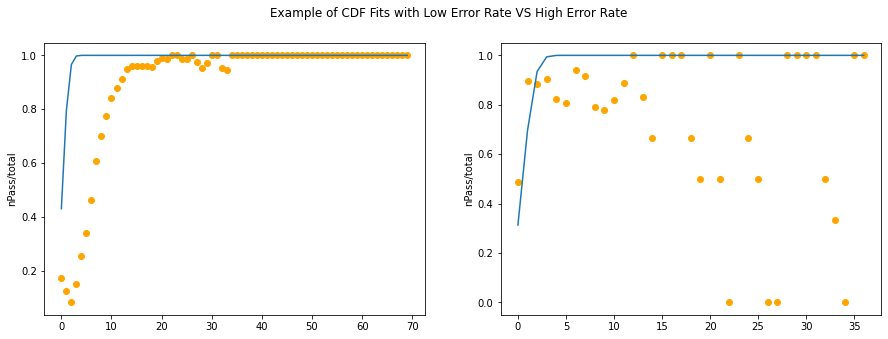

In [13]:
# visualization example beatmaps
good = 713935
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Example of CDF Fits with Low Error Rate VS High Error Rate')
x1 = range(len(find_nPassOverTotal_for_one_beatmap(good)))
y1 = find_nPassOverTotal_for_one_beatmap(good)
ax1.plot(scipy.stats.norm(find_nPassOverTotal_for_one_beatmap(good)[0]).cdf(x1))
ax1.scatter(x1, y1, color = "orange")
ax1.set(ylabel = "nPass/total")

bad = 848233
x2 = range(len(find_nPassOverTotal_for_one_beatmap(bad)))
y2 = find_nPassOverTotal_for_one_beatmap(bad)
ax2.plot(scipy.stats.norm(find_nPassOverTotal_for_one_beatmap(bad)[0]).cdf(x2))
ax2.scatter(x2, y2, color = "orange")
ax2.set(ylabel = "nPass/total")

In [14]:
unsuccessful_bm = {id: fitAndMse for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse, str)}
n = len(fitted_curves_with_errors)
success_rate = (n - len(unsuccessful_bm))/n
avg_mse = np.mean([fitAndMse[1] for (id, fitAndMse) in fitted_curves_with_errors.items() if isinstance(fitAndMse[1], float)])
print("success rate for all is:", success_rate)
print("average mse for all is:", avg_mse)

success rate for all is: 0.9996666666666667
average mse for all is: 0.03714103365330562


## Load the beatmap attribs data

In [60]:
bm_attribs_data = {}
for i in bm_ids:
    bm_attribs_data[i] = list(db['osu_beatmap_attribs'].find({"beatmap_id": i, "mods": 0, "attrib_id":17}, {"_id": 0, "value": 1}))

In [ ]:
create a data frame
rows are bm_ids
columns are mean, std, mse, value

## Visualisations of correlation between CDF mean/std with attribs
**Note:** Each beatmap maps the same mean, sd, mse mapped to its different attrib_ids

In [64]:
# creating a dataframe with rows as bm_ids and columns as mean, std, mse, and star difficulties
attrib_array = []
mean_array = []
sd_array = []
mse_array = []
successful_ids = [bm for bm in bm_ids if bm not in unsuccessful_bm.keys()]
for bm in successful_ids:
    attrib_array.append(bm_attribs_data[bm][0]["value"])
    mean_array.append(fitted_curves_with_errors[bm][0][0]) 
    sd_array.append(fitted_curves_with_errors[bm][0][1]) 
    mse_array.append(fitted_curves_with_errors[bm][1])

In [66]:
new_df = pd.DataFrame(successful_ids)
new_df["star"] = np.array(attrib_array)
new_df["mean"] = np.array(mean_array)
new_df["sd"] = np.array(sd_array)
new_df["mse"] = np.array(mse_array)
new_df.columns = ["Successful_ids", "Star_difficulties", "Mean", "Sd", "MSE"]
new_df

,Successful_ids,Star_difficulties,Mean,Sd,MSE
0,453359,1.75883,0.179988,0.661276,0.047169
1,315550,1.71815,0.019015,0.608820,0.136021
2,397536,1.68301,0.062281,0.696674,0.029173
3,397534,2.67792,0.191140,1.401044,0.030033
4,1442771,1.60975,0.193121,0.532542,0.061934
...,...,...,...,...,...
2994,355283,3.18799,4.361921,5.235403,0.002739
2995,133612,1.44691,-23.762525,31.595397,0.041346
2996,941270,4.80493,16.439372,12.596395,0.016654
2997,681786,4.38915,7.687208,5.267253,0.029396


[Text(0.5, 1.0, 'MSE from CDF against attrib')]

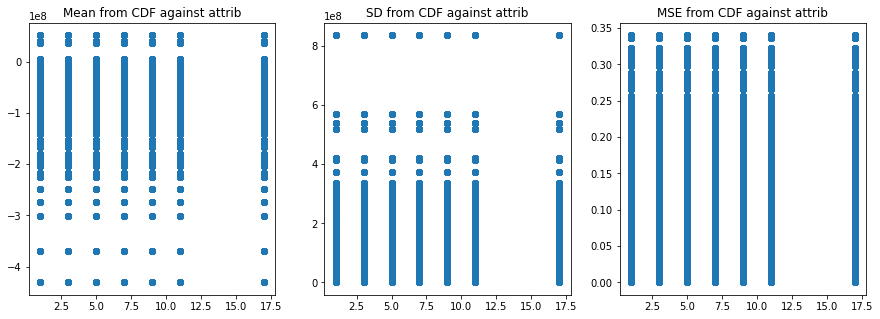

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
ax1.scatter(attrib_array, mean_array)
ax1.set(title = "Mean from CDF against attrib")
ax2.scatter(attrib_array, sd_array)
ax2.set(title = "SD from CDF against attrib")
ax3.scatter(attrib_array, mse_array)
ax3.set(title = "MSE from CDF against attrib")

## Fit success-rate summary table with 4 rows for each CDF fit
**Note:** 4 columns are (1,2,3), (4,5,6), (7,..), all. Original: (1 - 4, 4 - 6, 6 plus, all)

In [124]:
unsuccessful_attribs_data = bm_attribs_data[list(unsuccessful_bm.keys())[0]]
unsuccessful_attribs_array = [id_dict["attrib_id"] for id_dict in unsuccessful_attribs_data]
unsuccessful_low = unsuccessful_attribs_array.count(1) + unsuccessful_attribs_array.count(2) + unsuccessful_attribs_array.count(3)
unsuccessful_med = unsuccessful_attribs_array.count(4) + unsuccessful_attribs_array.count(5) + unsuccessful_attribs_array.count(6)
unsuccessful_high = len(unsuccessful_attribs_array) - unsuccessful_low - unsuccessful_med

successful_low = attrib_array.count(1) + attrib_array.count(2) + attrib_array.count(3)
successful_med = attrib_array.count(4) + attrib_array.count(5) + attrib_array.count(6)
successful_high = len(attrib_array) - successful_low - successful_med

In [131]:
success_summary = {
    "1-3": successful_low / (unsuccessful_low + successful_low),
    "4-6": successful_med / (unsuccessful_med + successful_med),
    "7+": successful_high / (unsuccessful_high + successful_high),
    "All": len(attrib_array) / (len(unsuccessful_attribs_array) + len(attrib_array))
}
pd.DataFrame(success_summary, index=[0])

,1-3,4-6,7+,All
0,0.999667,0.999667,0.999667,0.999667


## For curves that could be fit, error summary table with same layout as above

In [138]:
attrib_and_mse = list(zip(attrib_array, mse_array))
error_low_array = [aAndM[1] for aAndM in attrib_and_mse if aAndM[0] == 1 or aAndM[0] == 2 or aAndM[0] == 3]
error_med_array = [aAndM[1] for aAndM in attrib_and_mse if aAndM[0] == 4 or aAndM[0] == 5 or aAndM[0] == 6]
error_high_array = [aAndM[1] for aAndM in attrib_and_mse if aAndM[0] >= 7]

In [139]:
error_summary = {
    "1-3": np.mean(error_low_array),
    "4-6": np.mean(error_med_array),
    "7+": np.mean(error_high_array),
    "All": np.mean(mse_array)
}
pd.DataFrame(error_summary, index=[0])

,1-3,4-6,7+,All
0,0.037141,0.037141,0.037141,0.037141


# Exploring cdf based on t distr
**Note:** Under construction...

In [138]:
x = np.arange(len(find_nPassOverTotal_for_one_beatmap(1762729))).reshape(-1, 1)
# x = range(len(find_nPassOverTotal_for_one_beatmap(1762729)))
y = find_nPassOverTotal_for_one_beatmap(1762729).astype("int")
model = LogisticRegression().fit(x, y)

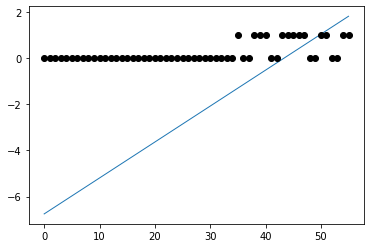

In [139]:
# model.predict_proba(x)

# and plot the result
plt.scatter(x, y, color='black', zorder=20)
# X_test = np.linspace(-5, 10, 300)

plt.plot(x, model.coef_ * x + model.intercept_, linewidth=1)
# plt.axhline(.5, color='.5')

# plt.ylabel('y')
# plt.xlabel('X')
# plt.xticks(range(-5, 10))
# plt.yticks([0, 0.5, 1])
# plt.ylim(-.25, 1.25)
# plt.xlim(-4, 10)
# plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
#            loc="lower right", fontsize='small')
# plt.tight_layout()
# plt.show()

In [ ]:
def fit_t_cdf(y):

    """Fits a set of cartesian points to the normal cdf

    Parameters
    ----------
    x (int []):  Array of point x-coordinates
    n_users (int): Array of point y-coordinates

    Returns
    
    params (tuple): Tuple of parameters for the normal cdf
    error (float): Least squares error from points given
    """

    x = range(0, len(y))
    try:
        df = len(y) - 1
        f = lambda x, mu,sigma: scipy.stats.t(df).cdf(x)
        scipy.optimize.curve_fit(f, x, y)[0]
    
    except RuntimeError:
        print("error")
        return "Error - curve_fit failed"
    
    total = 0
    for i in x:
        error = (y[i] - scipy.stats.t(df).cdf(i))**2
        total += error
    
    mse = total / n
    
    return scipy.stats.norm(mu,sigma).cdf(x), mse

    pass

In [145]:
df = len(y) - 1

x = range(len(find_nPassOverTotal_for_one_beatmap(1762729)))
y = find_nPassOverTotal_for_one_beatmap(1762729)

f = lambda x: scipy.stats.t.cdf(df)
scipy.optimize.curve_fit(f, x, y)


ValueError: Unable to determine number of fit parameters.

## Conclusion
Don't forget to provide a conclusion